# Meta Learning For SGD Classification
#### Peter Ma | June 16th 2022
In this notebook we will demonstrate the usage of Meta Learning using an algorithm called REPTILE adapted for multi-label classification.

As an MVP we first look into a "one-versus-all" classification where by we build a binary classifier with `True` being a specific SDG and the `False` being anything else. In the complete version we will repeat this for each SDG.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# We define Meta Learning Phase
Here we define parameters for the meta-learning phase. 

The `Learning_rate` references the learning rate for the SGD optmizer used in the training loops. 

The `meta_step_size` is the step size for the trajectory of the weights. Meta learning works by training the data and observing the finite differences between the weights at training and extending that trajectory in hopes to further tune the model to the dataset without needing more data samples. 



In [2]:
learning_rate = 0.001
meta_step_size = 0.3



inner_batch_size = 50
eval_batch_size = 50

meta_iters = 1000
eval_iters = 5
inner_iters = 10

eval_interval = 1
train_shots = 50
shots = 5
classes = 2


# Dataset Class
The dataset object works in conjunction with the custom training set up we have for the meta-learning phase. 

The main functionality is the `get_mini_dataset` function where we randomly sample various classes of certain sizes and certain number of samples from each class and returning it to be used for the few shot training.

In [3]:
import pandas as pd 


class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.

        self.data ={}
        text = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/X_train.pkl')
        labels = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/y_train.pkl')

        for i in range(len(text)):
            text_el = text[i]
            label_el =  labels[i]
            if label_el not in self.data:
                self.data[label_el] = []
            self.data[label_el].append(text_el)
        
        self.labels = list(self.data.keys())
        self.test = []

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots), dtype='U20000')
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes), dtype='U20000')

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = np.array(random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                ))

                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
                self.test  = np.array(random.choices(self.data[label_subset[class_idx]], k=shots))

            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = np.array(random.choices(self.data[label_subset[class_idx]], k=shots))
                self.test  = np.array(random.choices(self.data[label_subset[class_idx]], k=shots))

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.unicode_), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)
dataset, test_images, test_labels = test_dataset.get_mini_dataset(batch_size=2, repetitions=2, shots=2, num_classes=2, split=True)
print(test_images)


['abstract introduction: adiponectin (adipoq), involved in regulating glucose levels and fatty acid oxidation, plays key roles in  metabolic derangements such as gestational diabetes mellitus (gdm). previously, several studies have been conducted to  assess the association between adipoq +45 t/g polymorphism and risk of gdm. the results, however, are inconclusive.  we aimed to evaluate the effect of the polymorphism on the risk of gdm using a meta-analysis. materials  and  methods:  after  databases  searching,  eight  records  were  identified.  pooled  odds  ratios  (ors)  with  their corresponding 95% confidence intervals (cis) were used to evaluate the association between adipoq +45 t/g  polymorphism and risk of gdm. results: no significant association was observed between the adipoq +45 t/g polymorphism and the risk of gdm  (heterozygote  comparison:  or  =  1.15,  95%  ci,  0.70–1.89;  homozygote  comparison:  or  =  1.21,  95%  ci,  0.48–3.03;  dominant model: or = 0.86, 95% ci,

# Sanity Check
Here we just check whether the data is correctand that no "weird things" occured in adapting the dataset object for text samples. 

In [4]:
dataset, test_images, test_labels = test_dataset.get_mini_dataset(batch_size=2, repetitions=2, shots=2, num_classes=2, split=True)
print(test_images)
print(test_labels)
print(test_dataset.data)

['abstract epstein, leonard h., yow-wu b. wu, rocco a. paluch, frank j. cerny, and joan p. dorn. asthma and maternal body mass index are related to pediatric body mass index and obesity: results from the third national health and nutrition examination survey. obes res. 2000;8:575–581. objective: clinical research has shown an increased preva- lence of obesity in children with asthma. this study was designed to assess the relationship between asthma and pediatric body mass index (bmi) in a national database and to examine factors that may modify this relationship. design: the cross-sectional relationship between asthma and pediatric bmi and obesity (bmi $ 85th percentile) was studied. variables that may influence the relationship be- tween asthma and pediatric bmi, such as race/ethnicity and television watching were included in the model for the total sample. a smaller sample of 3009 white and african amer- ican youth were studied in regression models including maternal bmi. study popul

In [5]:
test_dataset.data[0][0]

'abstract the present study has been undertaken to examine the growth trajectory of the higher education (he) sector across all  the countries in the gcc (gulf cooperation council) region, the transition toward internationalization, quality initiatives  undertaken, and movement toward regional integration. the study aims to provide a review for the shifting paradigm through  concepts of internationalization in the literature review and to probe on the themes facing the gcc in their adaptation  to internationalization. the study is based on secondary data, mainly of the websites of 167 universities/higher education  institutions (heis) of gcc, which were analyzed for their adaptation to internationalization. the results show the various  perspectives of internationalization with the suggestion on regional integration. it is hoped the study would provide the heis  and the policy makers with a strong foundation on their internationalization efforts.'

In [6]:
print(test_images.shape)

(2,)


# Build BERT Model
Here we grab the BERT model from keras model hub to be used for our classification problem. 

In [7]:
!pip install -q tf-models-official==2.7.0
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.7 MB/s 
     |████████████████████████████████| 48.3 MB 3.4 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 92 kB 12.0 MB/s 
     |████████████████████████████████| 352 kB 66.9 MB/s 
     |████████████████████████████████| 99 kB 963 kB/s 
     |████████████████████████████████| 1.1 MB 61.6 MB/s 
     |████████████████████████████████| 596 kB 45.1 MB/s 
     |████████████████████████████████| 237 kB 72.7 MB/s 
     |████████████████████████████████| 4.6 MB 60.9 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 511.7 MB 4.4 kB/s 
     |████████████████████████████████| 4.9 MB 60.5 MB/s 


In [8]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pickle
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
from sklearn.metrics import accuracy_score
import numpy as np

# Model Selection
BERT alone is huge, for this use case we will be looking at a smaller version of BERT. For this example the model `small_bert/bert_en_uncased_L-4_H-512_A-8`. Feel free to experiment with other models. 

In [9]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Read Data
Note here we pick datasets from the following examples for SDG number 3. Below are the training and the test datasets.

In [10]:
text = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/X_train.pkl')
labels = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/y_train.pkl')


a = np.array(labels)
labels_onehot = np.zeros((a.size, a.max()+1))
labels_onehot[np.arange(a.size),a-1] = 1
print(labels_onehot.shape)

print(text)
print(labels)

(205, 2)


In [11]:
text_test = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/X_test.pkl')
labels_test = pd.read_pickle('/content/drive/MyDrive/ai4good/binary_class_data/y_test.pkl')

a = np.array(labels_test)
labels_onehot_test = np.zeros((a.size, a.max()+1))
labels_onehot_test[np.arange(a.size),a-1] = 1
print(labels_onehot_test.shape)

(101, 2)


# Model Construction
Now we grab the BERT model and we attach a simple fully connected neural network with all parameters tuneable

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(128, activation='relu', name='Dense2')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(64, activation='relu', name='Dense3')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [15]:
model = build_classifier_model()
bert_raw_result = model(tf.constant(text))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

# Meta Training

Here we have the meta learning phase. 

In [16]:
meta_step_size = 0.3
optimizer = keras.optimizers.SGD(learning_rate=0.001)

training = []
testing = []
score_history = []
trial_num = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
      # for some reason the 71'st element has a boolean layer so we skip updating
      # it to avoid errors. 
      if var !=71:
          new_vars[var] = old_vars[var] + (
              (new_vars[var] - old_vars[var]) * cur_meta_step_size
          )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds, axis=1).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 10 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )
            scores = accuracy_score(labels_test, model.predict(text_test).argmax(axis=-1))
            print("Test scores Accuracy: ",scores)
            score_history.append(scores)
            trial_num.append(meta_iter)

batch 0: train=0.500000 test=0.500000
0.5742574257425742
batch 10: train=0.500000 test=1.000000
0.6237623762376238
batch 20: train=0.500000 test=1.000000
0.5148514851485149
batch 30: train=1.000000 test=1.000000
0.2079207920792079
batch 40: train=1.000000 test=1.000000
0.44554455445544555
batch 50: train=1.000000 test=0.500000
0.594059405940594
batch 60: train=0.500000 test=0.500000
0.27722772277227725
batch 70: train=1.000000 test=0.000000
0.48514851485148514
batch 80: train=0.500000 test=0.500000
0.19801980198019803
batch 90: train=1.000000 test=0.500000
0.7623762376237624
batch 100: train=1.000000 test=1.000000
0.7425742574257426
batch 110: train=1.000000 test=0.500000
0.42574257425742573
batch 120: train=0.500000 test=0.500000
0.8514851485148515
batch 130: train=0.500000 test=0.500000
0.8415841584158416
batch 140: train=1.000000 test=1.000000
0.6138613861386139
batch 150: train=0.500000 test=0.000000
0.42574257425742573
batch 160: train=0.500000 test=1.000000
0.6138613861386139
bat

In [17]:
print(max(score_history))

0.8514851485148515


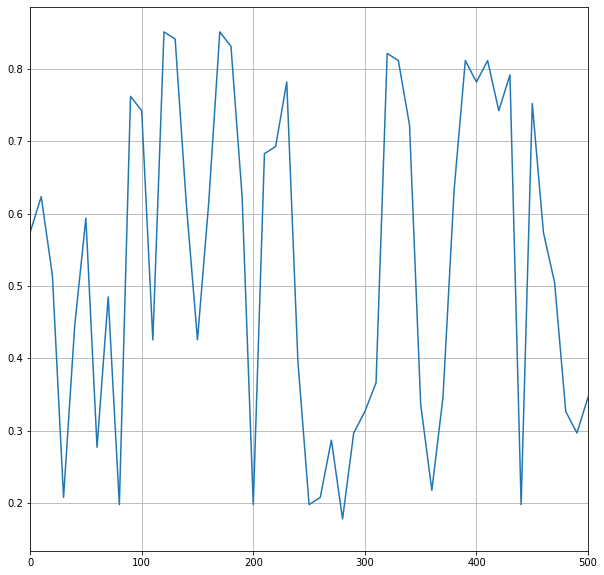

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10,10))
plt.plot(trial_num, score_history)
plt.xlim(0,500)
plt.grid()